In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from scipy.signal import convolve2d
import numba

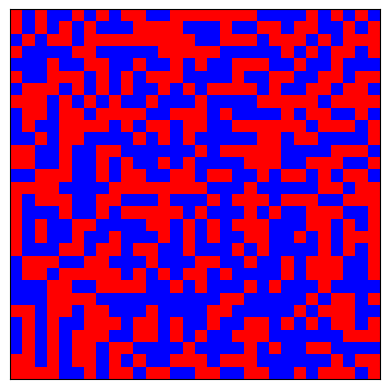

In [3]:
N = 30
spins = np.random.choice([-1, 1], (N, N))

# Visualise a random arrangement of spins  

cmp = ListedColormap(['red', 'blue'])
plt.imshow(spins, cmap=cmp, vmin=-1, vmax=1)
plt.tick_params(bottom=False, top=False, left=False, 
                right=False, labelbottom=False, labelleft=False) 
plt.show()

In [4]:
# Performs the Metropolis algorithm, sweep through the lattice and calculate 
# acceptance ratio r from energies, and flip spin with probability r
# Use numba (compiles Python to machine code) for almost 100x speedup
# Input: S_init (initial matrix of spins), JkT, BkT (values of J/kT and B/kT) 
# Output S_next (matrix of spins after sweep iteration)

@numba.jit(nopython=True)
def sweep(S_init, JkT, BkT):
    S_next = np.copy(S_init)
    for iy, ix in np.ndindex(S_next.shape):
        spinCoupling = S_next[iy, ix] * S_next[(iy + 1) % N, ix]
        spinCoupling += S_next[iy, ix] * S_next[iy - 1, ix]
        spinCoupling += S_next[iy, ix] * S_next[iy, (ix + 1) % N]
        spinCoupling += S_next[iy, ix] * S_next[iy, ix - 1]
        deltaE = 2 * JkT * spinCoupling - 2 * BkT * S_next[iy, ix]
        r = np.exp(-deltaE)
        rand = np.random.uniform()
        if r > rand:
            S_next[iy, ix] *= -1
    return S_next

In [5]:
neighbours = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])

# Calculate energy by adding up spin-spin interaction and applied magnetic field
# Remember to divide first term by 2 to account for double counting of pairs
# Use convolution for efficient neighbour sum
def energy(spins, JkT, BkT):
    convolve = convolve2d(spins, neighbours, mode='same', boundary='wrap')
    return -JkT * (spins * convolve).sum() / 2 + BkT * spins.sum() 

In [6]:
# Simulate the system for particular values of JkT and BkT 
# and store magnetic moments and energies 

spinsList = []
magneticMoments = []
energies = []

JkT = 0.5
BkT = 0.0

n_iterations = 2000

spins = np.random.choice([-1, 1], (N, N))

for i in range(n_iterations):
    spinsList.append(spins)
    magneticMoments.append((spins.sum()))
    energies.append(energy(spins, JkT, BkT))
    spins = sweep(spins, JkT, BkT)

energies = np.array(energies)
magneticMoments = np.array(magneticMoments)

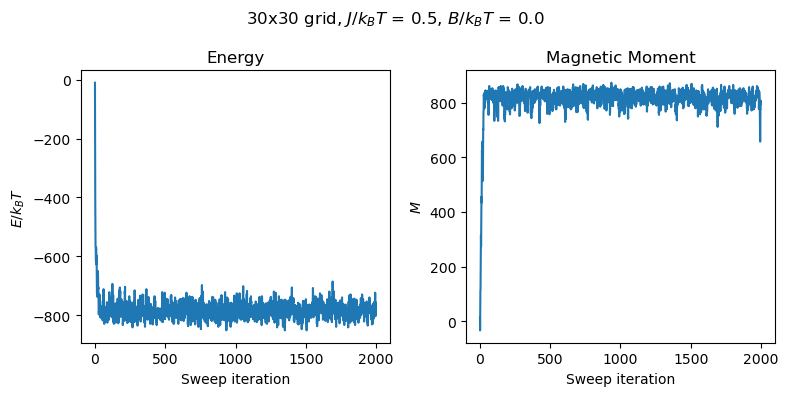

In [7]:
# Plot the magnetic moment and energy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

fig.suptitle(f"{N}x{N} grid, $J/k_BT$ = {JkT}, $B/k_BT$ = {BkT}")

ax1.set_title("Energy")
ax1.plot(energies)
ax1.set_xlabel("Sweep iteration")
ax1.set_ylabel("$E/k_BT$")

ax2.set_title("Magnetic Moment")
ax2.plot(magneticMoments)
ax2.set_xlabel("Sweep iteration")
ax2.set_ylabel("$M$")

fig.tight_layout()

plt.show()

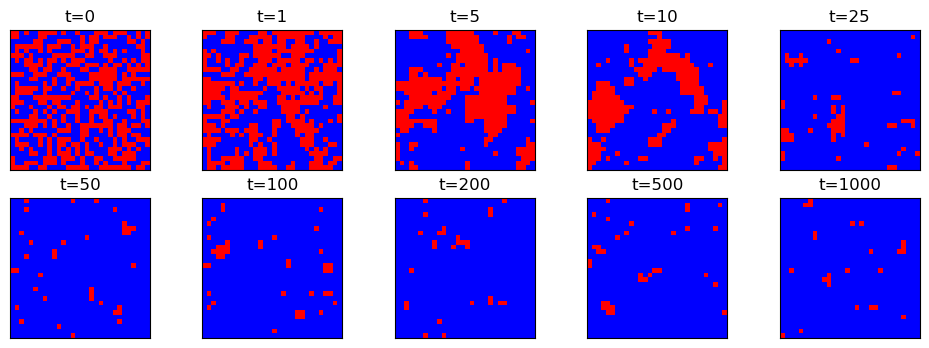

In [8]:
# Visualise the lattice at specific time intervals

times = [0, 1, 5, 10, 25, 50, 100, 200, 500, 1000]

fig, axs = plt.subplots(2, 5, figsize=(12,4))

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_title(f"t={times[i]}")
    ax.tick_params(bottom=False, top=False, left=False, 
                   right=False, labelbottom=False, labelleft=False) 
    ax.imshow(spinsList[times[i]], cmap=cmp, vmin=-1, vmax=1)

plt.show()

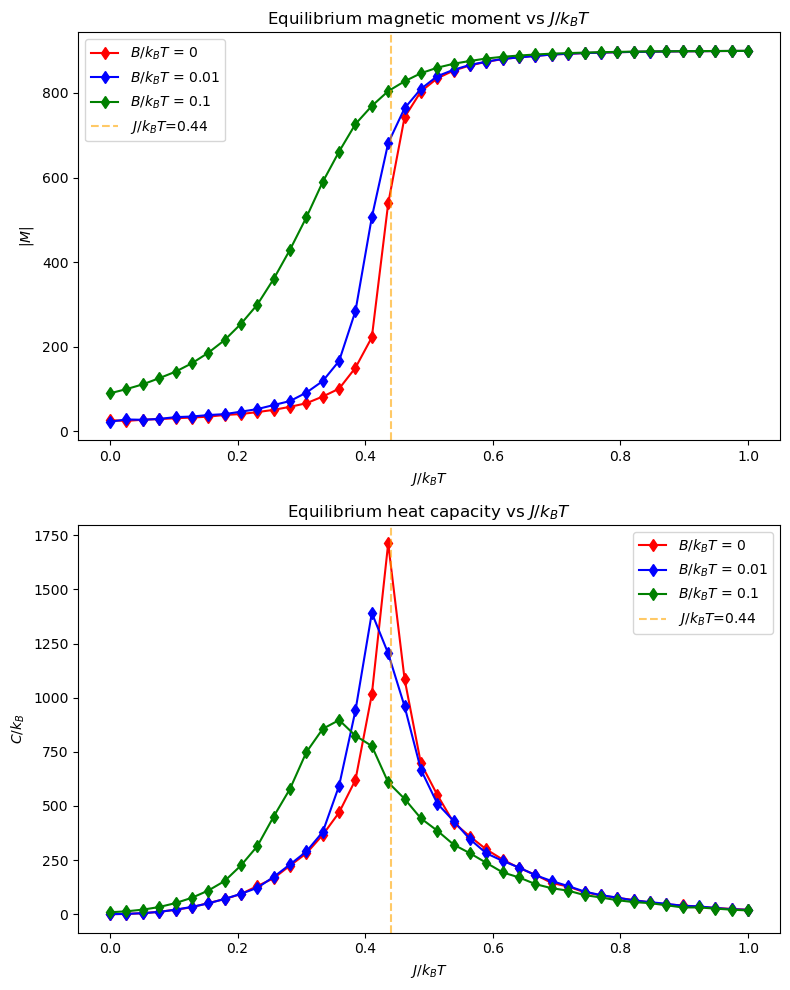

In [9]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8,10))

n_iterations = 5000

BList = [0, 0.01, 0.1]
JList = np.linspace(0, 1, 40)

colors = ["red", "blue", "green"]

# Simulate system for various values of JkT and BkT
for i, BkT in enumerate(BList):
    avgMagMoments = []
    avgHeatCapacities = []
    avgSusceptibilities = []

    for JkT in JList:
        magneticMoments = []
        energies = []
        spins = np.random.choice([-1, 1], (N, N))

        for n in range(n_iterations):
            magneticMoments.append(np.abs(spins.sum()))
            energies.append(energy(spins, JkT, BkT))
            spins = sweep(spins, JkT, BkT)

        # Calculate averages of heat capacity and magnetic moment at equilibrium
        # Wait roughly 2000 iterations for burn in period

        magneticMoments = np.array(magneticMoments)
        energies = np.array(energies)
        avgMagMoments.append(np.mean(magneticMoments[2000:]))
        avgHeatCapacities.append(np.var(energies[2000:]))

    # Plot heat capacity/magnetic moment vs JkT for different values of BkT
    ax1.plot(JList, avgMagMoments, c=colors[i], 
             marker="d", label=f"$B/k_BT$ = {BkT}")
    ax2.plot(JList, avgHeatCapacities, c=colors[i], 
             marker="d", label=f"$B/k_BT$ = {BkT}")

criticalPoint = 0.44

ax1.axvline(criticalPoint, color="orange", alpha=0.6, 
            linestyle='--', label=f"$J/k_BT$={criticalPoint}")
ax1.set_xlabel("$J/k_BT$")
ax1.set_ylabel("$|M|$")
ax1.set_title("Equilibrium magnetic moment vs $J/k_BT$")
ax1.legend()

ax2.axvline(criticalPoint, color="orange", alpha=0.6, 
            linestyle='--', label=f"$J/k_BT$={criticalPoint}")
ax2.set_xlabel("$J/k_BT$")
ax2.set_ylabel("$C/k_B$")
ax2.set_title("Equilibrium heat capacity vs $J/k_BT$")
ax2.legend()

fig.tight_layout()

plt.show()

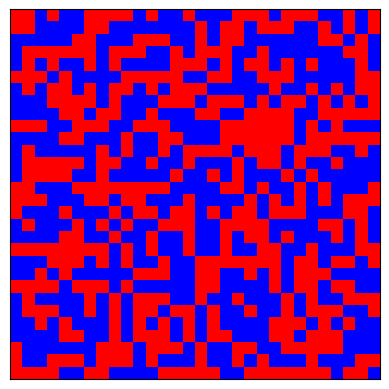

In [11]:
# Extra code for creating animation of the lattice of spins
fig, ax = plt.subplots()
ax.tick_params(bottom=False, top=False, left=False, 
               right=False, labelbottom=False, labelleft=False) 

grid = ax.imshow(spins, cmap=cmp, vmin=-1, vmax=1)

n_iterations = 2000

def animate(i):
    grid.set_data(spinsList[i])
    return grid

anim = animation.FuncAnimation(fig, animate, 
                               frames=n_iterations, interval=50)
anim.save("ising_model.mp4")